# Expectation over Transformation (EoT) - Rotation

This notebook demonstrates the application of ART's tools for expectation over transformation (EoT) sampling in `art.preprocessing.expectation_over_transformation`. Specifically, it shows how to create adversarial examples that are robust against rotation. This notebook follows a tutorial by Anish Athalye (https://www.anishathalye.com/2017/07/25/synthesizing-adversarial-examples/) and code from issue #1004.

Install ImageNet stubs and [tensorflow-addons](https://www.tensorflow.org/addons)

In [1]:
#%pip install git+https://github.com/nottombrown/imagenet_stubs tensorflow_addons

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-kx_74a1u
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-kx_74a1u
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 11.6 MB/s eta 0:00:00
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794798 sha256=93843a788effc81b0b09f01025370586ea7d37bf503f58bbb81e969b22d08c96
  Stored in directory: /tmp/pip-ephem-wheel-cache-pqe4gpjm/wheels/11/fe/f6/71c84cfe4ee113c44af28273d506ccbd346c66da9db8688fe6
Successfully built imagenet-stubs


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.inception_v3 import InceptionV3

import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name, name_to_label

from art.estimators.classification import TensorFlowV2Classifier
from art.preprocessing.expectation_over_transformation import EoTImageRotationTensorFlow
from art.attacks.evasion import ProjectedGradientDescent

In [3]:
np.random.seed(1234)

In [4]:
def plot_prediction(img, probs, correct_class=None, target_class=None):

    # Initialize the subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))

    # Set the first plot to the input image
    fig.sca(ax1)
    ax1.imshow(img)

    # Determine the top ten labels and store them with their probabilities
    top_ten_indexes = list(probs[0].argsort()[-10:][::-1])
    top_probs = probs[0, top_ten_indexes]
    labels = [label_to_name(i) for i in top_ten_indexes]
    barlist = ax2.bar(range(10), top_probs)
    if target_class in top_ten_indexes:
        barlist[top_ten_indexes.index(target_class)].set_color('r')
    if correct_class in top_ten_indexes:
        barlist[top_ten_indexes.index(correct_class)].set_color('g')

    # Plot the probabilities and labels
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10), labels, rotation='vertical')
    plt.ylabel("Probability")
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Step 1: Define parameters

In [5]:
# parameters that can be modified for experimentation

eps = 8.0 / 255.0 # Attack budget for PGD
eps_step = 2.0 / 255.0 # Step size for PGD
num_steps = 30 # Number of iterations for PGD
y_target = np.array([name_to_label("guacamole")])  # Target class for the attack is "guacamole"
angle_max = 22.5 # Rotation angle used for evaluation in degrees
eot_angle = angle_max # Maximum angle for sampling range in EoT rotation, applying range [-eot_angle, eot_angle]
eot_samples = 10 # Number of samples with random rotations in parallel per loss gradient calculation

# constant parameters
nb_classes = 1000 # Number of ImageNet classes
preprocessing = (0.5, 0.5) # Preprocessing with (mean, std) for InceptionV3 from input image range [0, 1]
clip_values=(0.0, 1.0) # Clip values for range [0, 1]
input_shape = (299, 299, 3) # Shape of input images

## Step 2: Load ImageNet data and labels

In [6]:
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    im = tf.keras.preprocessing.image.img_to_array(im)
    if 'tractor.jpg' in image_path:
        x = np.array(im)
x = (np.expand_dims(x, axis=0) / 255.0).astype(np.float32)
y = np.array([name_to_label("tractor")])

In [7]:
img=x.copy()

## Step 2: Load InceptionV3 model and define cross-entropy loss

In [8]:
model = InceptionV3(include_top=True, weights='imagenet', classifier_activation='softmax')

96112376/96112376 [==============================] - 1s 0us/step


In [9]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

## Step 3: Create the ART Classifier (without EoT) and targeted PGD attack

In [10]:
classifier = TensorFlowV2Classifier(model=model,
                                    nb_classes=nb_classes,
                                    loss_object=loss,
                                    preprocessing=preprocessing,
                                    preprocessing_defences=None,
                                    clip_values=clip_values,
                                    input_shape=input_shape)

In [11]:
attack = ProjectedGradientDescent(estimator=classifier,
                                  eps=eps,
                                  max_iter=num_steps,
                                  eps_step=eps_step,
                                  targeted=True)

## Step 4: Generate and evaluate adversarial examples (without EoT)

In [12]:
# Generate adversarial examples
x_adv = attack.generate(x=x, y=y_target)

PGD - Batches: 0it [00:00, ?it/s]

### Evaluate adversarial example in original image orientation

The targeted PGD attack (code and plots below) create a very successful adversarial example which is classified as `guacamole` with high confidence (red bar).

<font color='green'>Green bars</font> : correct classification<br>
<font color='red'>Red bars</font>: attack target classification<br>
<font color='blue'>Blue bars</font>: other classifications<br>

In [13]:
# Get predictions on adversarial examples
y_pred_adv = classifier.predict(x_adv)

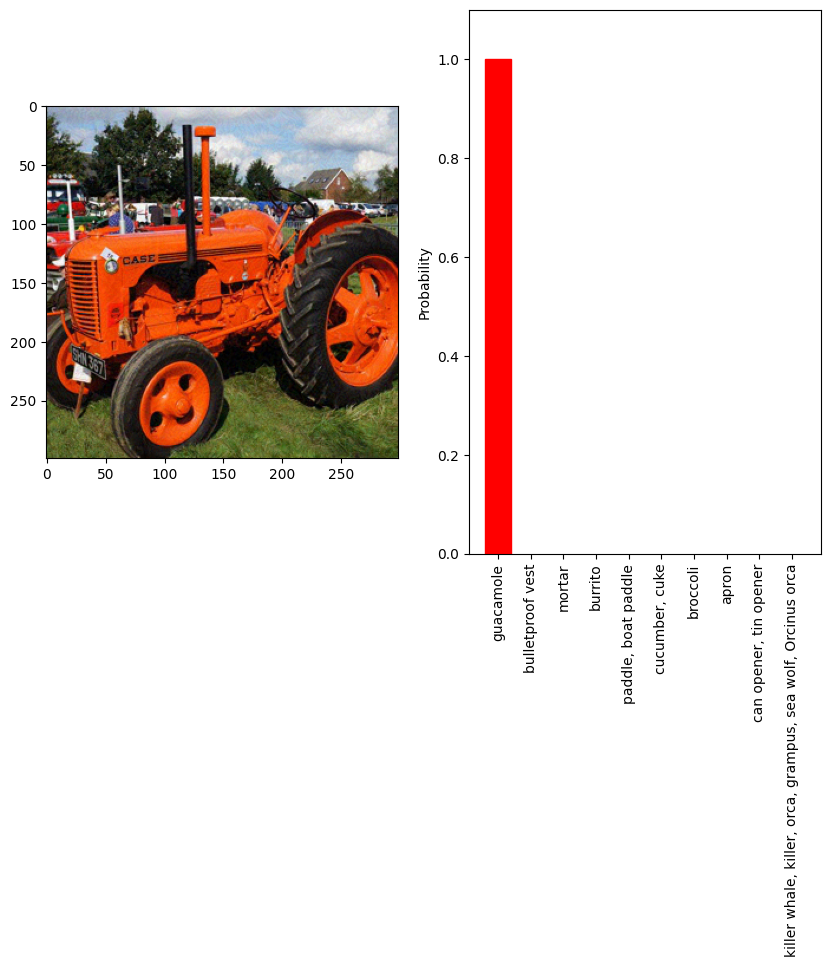

In [14]:
# Evaluate results
plot_prediction(np.squeeze(x_adv), y_pred_adv, correct_class=y, target_class=y_target)

### Evaluate adversarial example in rotated orientation

Rotating the adversarial example of the previous section lets it loose all of its adversarial properties and the classifier again classifies it correctly with high confidence (green bar). The adversarial perturbation is still present in the rotated image.

In [15]:
# Rotate adversarial example
x_adv_rotated = scipy.ndimage.rotate(x_adv, angle=angle_max, reshape=False, axes=(1, 2), order=1)

In [16]:
# Get predictions on adversarial examples
y_pred_adv_rotated = classifier.predict(x_adv_rotated)

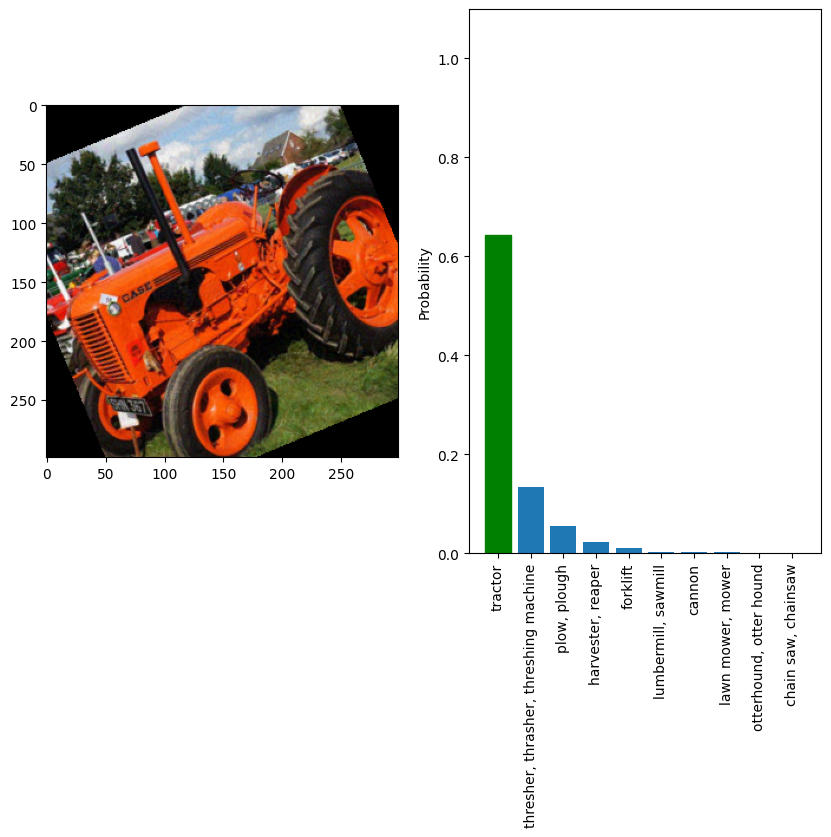

In [17]:
# Evaluate results
plot_prediction(x_adv_rotated[0], y_pred_adv_rotated, correct_class=y, target_class=y_target)

## Step 5: Apply Expectation over Transformation

To make the adversarial example robust against rotation we apply Expectation over Transformation (EoT) sampling using ART's `art.preprocessing.expectation_over_transformation.EoTImageRotationTensorFlow` tool. The instance `eot_rotation` will draw `eot_samples` samples and rotate each with a different random angle in each evaluation of the classifier model, including predictions and loss gradient calculations.

In [18]:
eot_rotation = EoTImageRotationTensorFlow(nb_samples=eot_samples,
                                          clip_values=clip_values,
                                          angles=eot_angle)

## Step 6: Create new ART Classifier with  EoT and new targeted PGD attack

The EoT sampling of rotations is added to `TensorFlowV2Classifier` in its argument `preprocessing_defences`.

In [19]:
classifier_eot = TensorFlowV2Classifier(model=model,
                                        nb_classes=nb_classes,
                                        loss_object=loss,
                                        preprocessing=preprocessing,
                                        preprocessing_defences=[eot_rotation],
                                        clip_values=clip_values,
                                        input_shape=input_shape)

In [20]:
attack_eot = ProjectedGradientDescent(estimator=classifier_eot,
                                      eps=eps,
                                      max_iter=num_steps,
                                      eps_step=eps_step,
                                      targeted=True)

## Step 7: Generate and evaluate adversarial examples generated with EoT

Applying EoT sampling of rotations to the classifier used by the attack generates adversarial examples that are robust against rotations. The plots below show that the adversarial example created in the previous section remains adversarial with high confidence for a large variety of rotation angles (red bars). The evaluation was done with predictions of the ART classifier without EoT, but the same classifier model, created first above, to not add additional rotation to the evaluated input.

In [21]:
# Stack the single image 'x' along the first axis to create a batch of images.
images = np.stack([x], axis=0).astype(np.float32)

In [22]:
# Generate adversarial examples
x_adv_eot = attack_eot.generate(x=images, y=y_target)

PGD - Batches: 0it [00:00, ?it/s]

Rotation angle: -22.5


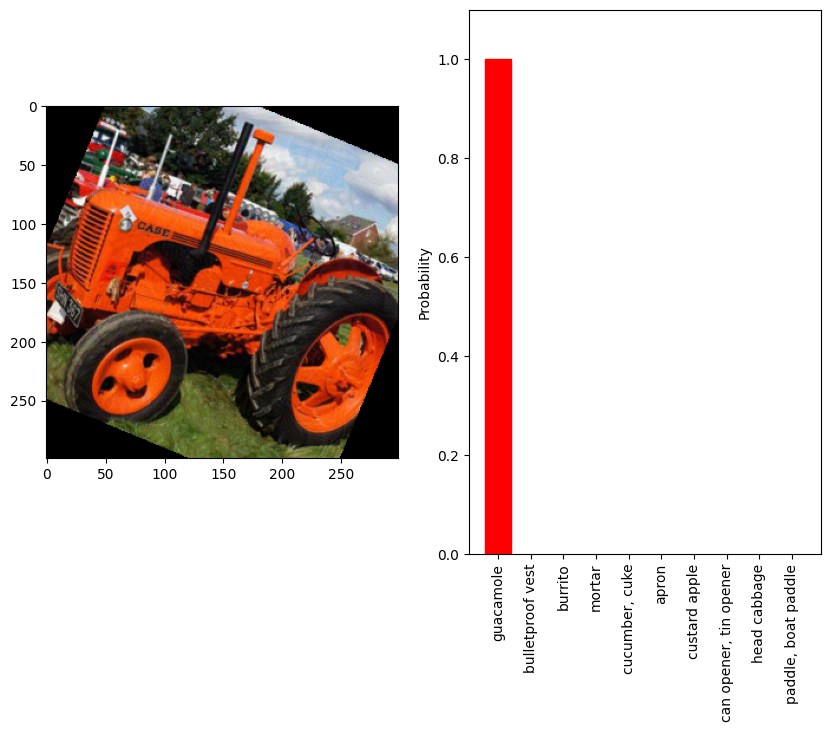

Rotation angle: -5.0


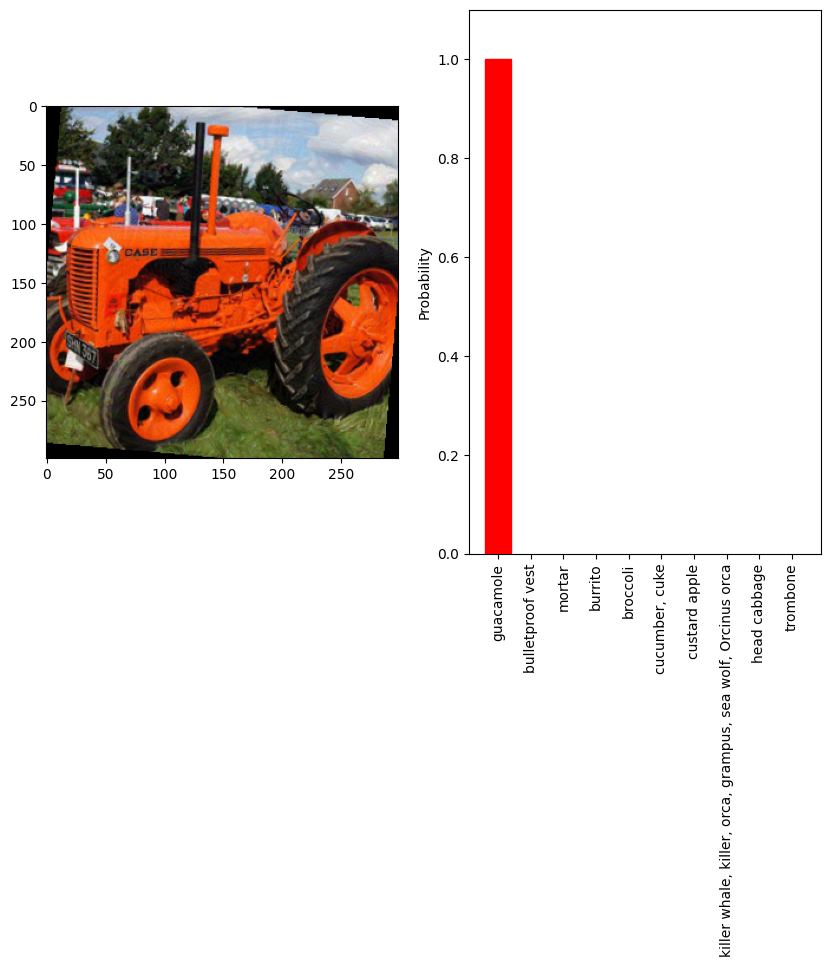

Rotation angle: 0.0


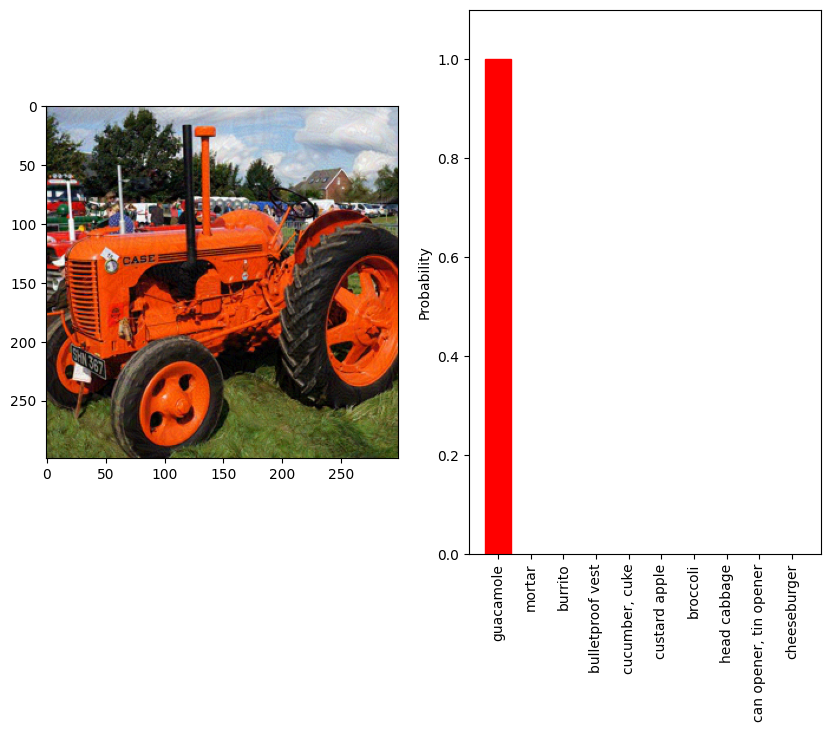

Rotation angle: 5.0


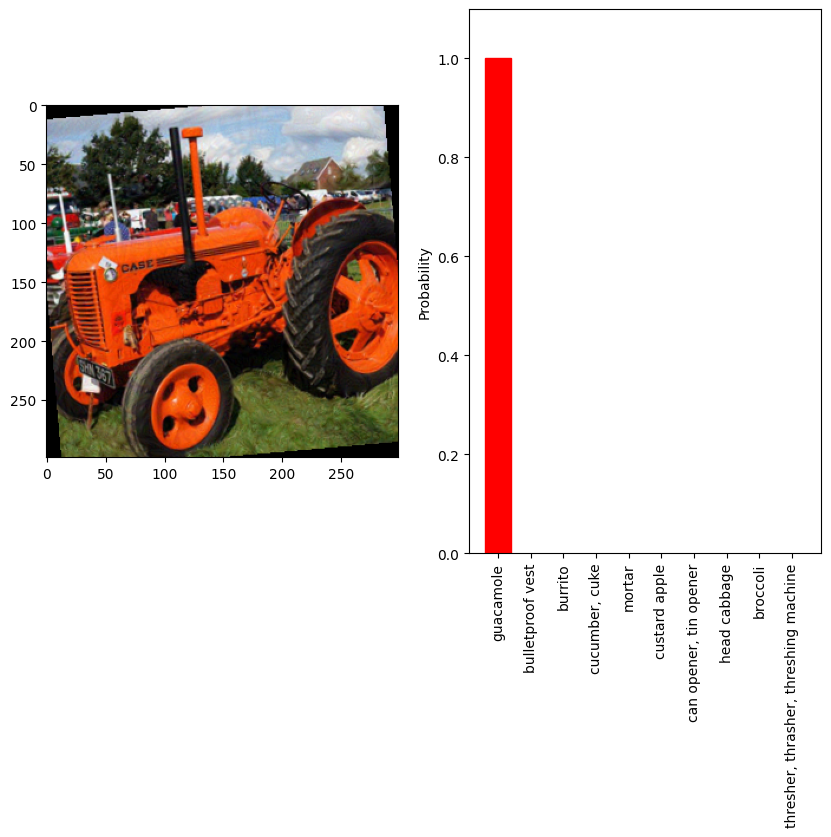

Rotation angle: 22.5


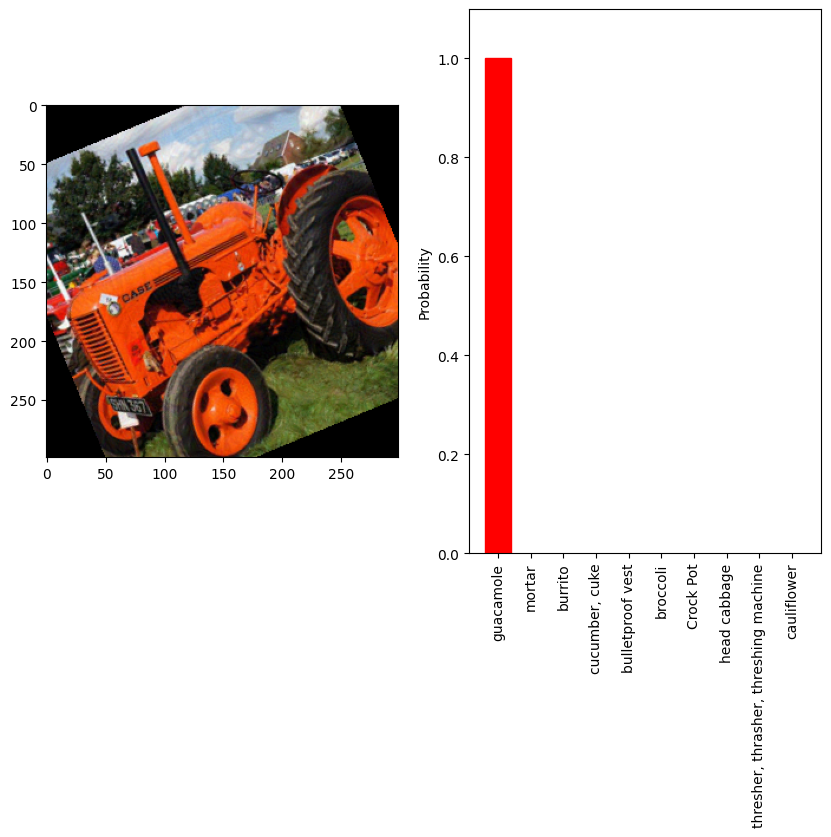

In [23]:
# Evaluate results for adversarial example rotated by various angles
for angle_i in [-22.5, -5.0, 0.0, 5.0, 22.5]:
    print("Rotation angle:", angle_i)

    # Rotate adversarial example
    x_adv_eot_rotated = scipy.ndimage.rotate(np.reshape(x_adv_eot, (1, 299, 299, 3)), angle_i, reshape=False, axes=(1, 2), order=1)

    # Get predictions on adversarial examples using the classifier without EoT
    y_pred_adv_eot_rotated = classifier.predict(x_adv_eot_rotated)

    # Evaluate results
    plot_prediction(x_adv_eot_rotated[0], y_pred_adv_eot_rotated, correct_class=y, target_class=y_target)